# analysis ar41 - cut 1m

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 20})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=1000):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
init = time.time()
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Neutrons_VariousConfig_08_20_2020")

fileinprefix = "SlicedDetections*100mmCylinder_01MeV*CutR1000*csv"
df_ar41 = load_dataframe_from_files(dirin, fileinprefix)
df_ar41 = df_ar41[df_ar41.columns[:-1]]

print("[Info] Loaded {} events in {:.3f} seconds".format(len(df_ar41), time.time() - init))

[Info] Loading 1 files wt prefix:
SlicedDetections*100mmCylinder_01MeV*CutR1000*csv

[Info] Loaded 4030764 events in 18.896 seconds


# select non-zero detections, trigger on 1st detection

In [4]:
df_nonzero = df_ar41[df_ar41.pedetected>0]
df_first_npe = df_nonzero.sort_values(["time"]).groupby("eventnumber").time.first().reset_index()
ext_df = df_nonzero.merge(df_first_npe, on="eventnumber", suffixes=["", "_1pe"])

In [5]:
print("[Info] All data: {} events, {} entries".format(df_ar41.eventnumber.nunique(), len(df_ar41)))
print("[Info] Non-zero detections: {} events, {} entries".format(df_nonzero.eventnumber.nunique(), len(df_nonzero)))

[Info] All data: 14279 events, 4030764 entries
[Info] Non-zero detections: 11733 events, 242153 entries


In [13]:
npe_gby = df_nonzero[df_nonzero.time<10**12].groupby("eventnumber").pedetected.sum()
len(npe_gby[npe_gby>=5])

8967

# see detections' time

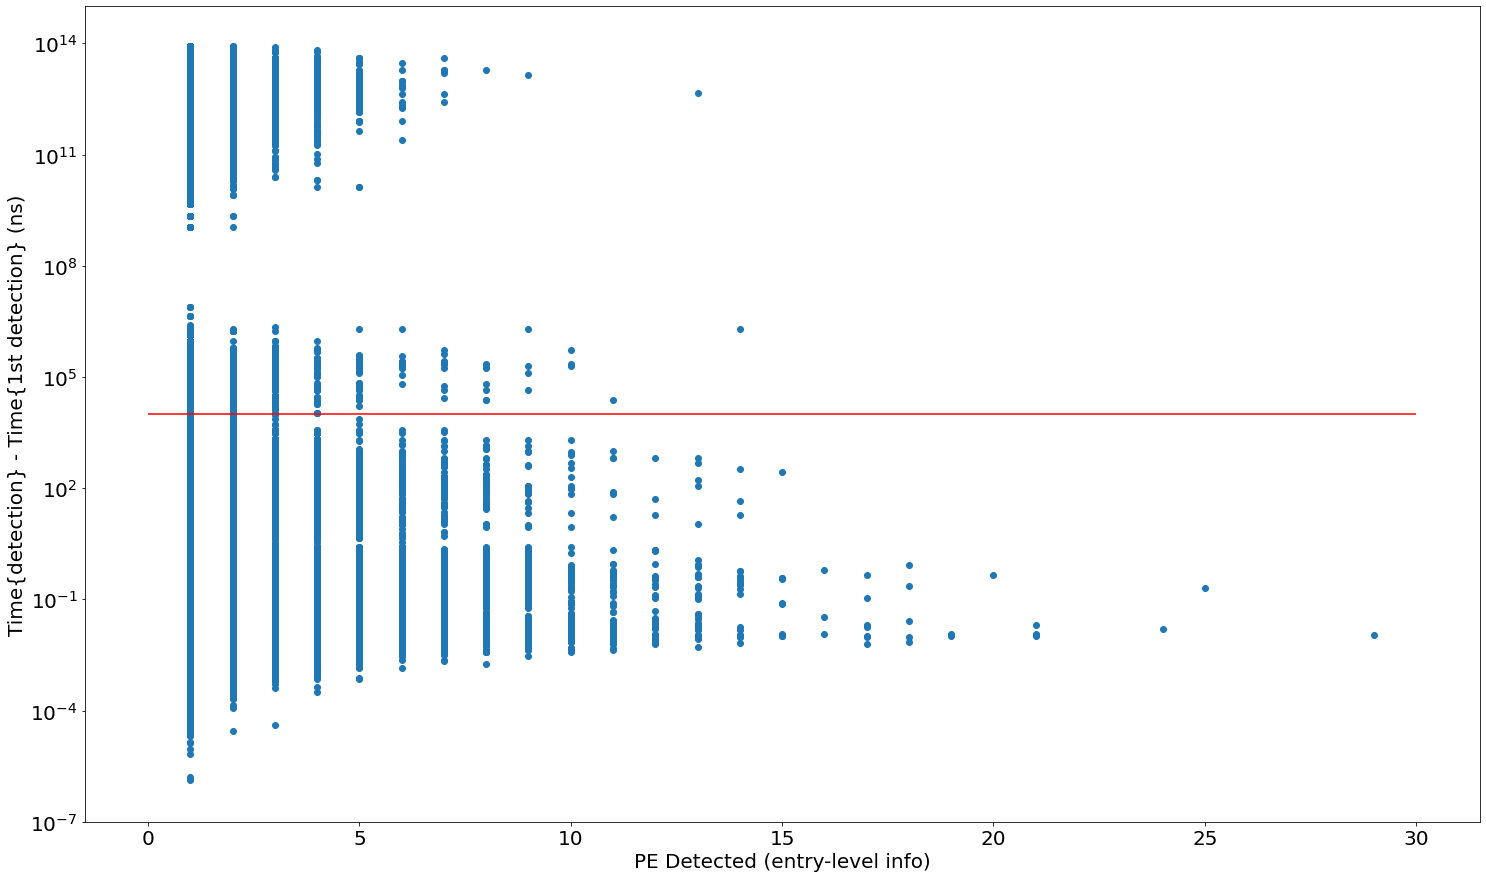

In [6]:
plt.scatter(ext_df.pedetected, ext_df.time-ext_df.time_1pe)
plt.hlines(10000, 0, 30, color='r')
plt.yscale("log")
plt.ylim(.0000001, 10**15)
plt.ylabel("Time{detection} - Time{1st detection} (ns)")
plt.xlabel("PE Detected (entry-level info)")
plt.show()

**Observation:** we cut all the delayed detections due to K41 production. However, it seems that we loose some delayed detections by Ar41. Can we define the trigger time in another way to capture all the energy?

# can we trigger on something else?
e.g. multiple "active" slices at the same time, NPE>1 at the same time

What do you mean for "at the same time"? Discretize at 4ns like ADC.

In [ ]:
delta_t = 4 #4 ns
ext_df["int_time"] = round(ext_df.time)
ext_df["discrete_time"] = round(ext_df.int_time / delta_t)

In [ ]:
# integrate over delta_t
discretized_df = ext_df.groupby(["eventnumber", "discrete_time"]).sum().reset_index()

In [ ]:
discretized_df[["eventnumber", "discrete_time", "int_time", "time", "energydeposition", "pedetected", 
                "InnerSlice0", "InnerSlice1", "InnerSlice2", "InnerSlice3", "InnerSlice4", "InnerSlice5",
                "InnerSlice6", "InnerSlice7", "InnerSlice8", "InnerSlice9", "InnerSlice10", "InnerSlice11",
                "OuterSlice0", "OuterSlice1", "OuterSlice2", "OuterSlice3", "OuterSlice4", "OuterSlice5", "OuterSlice6", "OuterSlice7", "OuterSlice8", "OuterSlice9",
                "OuterSlice10", "OuterSlice11", "OuterSlice12", "OuterSlice13", "OuterSlice14", "OuterSlice15", "OuterSlice16", "OuterSlice17", "OuterSlice18", "OuterSlice19"]]

In [ ]:
discretized_df[discretized_df.eventnumber==203][["pedetected", 
                "InnerSlice0", "InnerSlice1", "InnerSlice2", "InnerSlice3", "InnerSlice4", "InnerSlice5",
                "InnerSlice6", "InnerSlice7", "InnerSlice8", "InnerSlice9", "InnerSlice10", "InnerSlice11",
                "OuterSlice0", "OuterSlice1", "OuterSlice2", "OuterSlice3", "OuterSlice4", "OuterSlice5", "OuterSlice6", "OuterSlice7", "OuterSlice8", "OuterSlice9",
                "OuterSlice10", "OuterSlice11", "OuterSlice12", "OuterSlice13", "OuterSlice14", "OuterSlice15", "OuterSlice16", "OuterSlice17", "OuterSlice18", "OuterSlice19"]]

# see time correlation after discretization

In [ ]:
discretized_df_first_npe = discretized_df.sort_values(["discrete_time"]).groupby("eventnumber").discrete_time.first().reset_index()
ext_discretized_df = discretized_df.merge(discretized_df_first_npe, on="eventnumber", suffixes=["", "_disc_1pe"])

In [ ]:
plt.scatter(ext_discretized_df.pedetected, ext_discretized_df.discrete_time-ext_discretized_df.discrete_time_disc_1pe)
plt.hlines(10000/4, 0, 150, color='r')
plt.vlines(1, 0, 11**13, color='r')
plt.show()

In [ ]:
ext_discretized_df[ext_discretized_df.pedetected>0].eventnumber.nunique()

In [ ]:
discretized_df_first_2npe = discretized_df[discretized_df.pedetected>1].sort_values(["discrete_time"]).groupby("eventnumber").discrete_time.first().reset_index()

In [ ]:
discretized_df_2npe = discretized_df[(discretized_df.eventnumber.isin(discretized_df_first_2npe.eventnumber.unique()))]
ext_discretized_df_2npe = discretized_df_2npe.merge(discretized_df_first_2npe, on="eventnumber", suffixes=["", "_2pe"])

In [ ]:
plt.scatter(ext_discretized_df_2npe.pedetected, ext_discretized_df_2npe.discrete_time-ext_discretized_df_2npe.discrete_time_2pe)
plt.hlines(10000/4, 0, 150, color='r')
plt.vlines(1, 0, 11**13, color='r')
plt.ylim(0.000000000000000001, 10**6)
plt.yscale("log")
plt.show()

In [ ]:
(ext_discretized_df_2npe.discrete_time-ext_discretized_df_2npe.discrete_time_2pe).describe()